# AI Algoithms - Final Project
By: Tejas Vyas

## Scam job classification using NLP and Machine Learning

**Feature Engineering and Exploratory data analysis (EDA) available in the Data Acquisition and Understanding folder**

## Loading and pre-processing
Let's start by loading all necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score 
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
#pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

Our data is contained in fake_job_postings.csv, reading and verifying its loaded properly

In [2]:
# fake_job_postings.csv is our data file - loading it into pandas an verifying its loaded correctly
df = pd.read_csv('fake_job_postings.csv')
print("Data shape - ",df.shape)
df.head(3)

Data shape -  (17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


We need to check if the data contains any null values so we can clean it up

In [3]:
df = df.drop(columns=['job_id'])

In [4]:
text_df = df[["title", "company_profile", "description", "requirements", "benefits","fraudulent"]]
text_df = text_df.fillna(' ')

text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [5]:
data = pd.DataFrame(columns=['text','target'])
data.text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
data.target = df['fraudulent']

import string
def remove_punct(text):
  text_nopunct= "".join ([char for char in text if char not in string.punctuation])
  return text_nopunct
data.text=data.text.apply(lambda x:remove_punct(x))

import re
def tokenize(text):
  tokens = re.split('\W+', text)
  return tokens
data.text=data.text.apply(lambda x: tokenize(x.lower()))

import nltk
#nltk.download('stopwords')

stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(tokenized_list):
  text = [word for word in tokenized_list if word not in stopword]
  return text
def join_text(text):
    joined_text = ' '.join(text)
    return joined_text

data.text=data.text.apply(lambda x: remove_stopwords(x))
data.text=data.text.apply(lambda x : join_text(x))
data.head()

,text,target
0,marketing internwere food52 weve created groun...,0
1,customer service cloud video production90 seco...,0
2,commissioning machinery assistant cmavalor ser...,0
3,account executive washington dcour passion imp...,0
4,bill review managerspotsource solutions llc gl...,0


### We have 2 issues here:
1. The data is extremely skewed towards Real posts (Oversampling)
2. The number of features generated using vectorizer would yield sparse matrices needing more than 40GB of memory (Large feature set)

### To solve these:
- We decrease the number of real posts we consider to 2000 using a random sample, this allows us to train the models without going to cloud or increasing available memory

In addition, it was recommended we use an oversampling technique, so:
- We will use **SMOTE** technique to handle the oversampling

### Sampling

In [6]:
data["target"].value_counts()

0    17014
1      866
Name: target, dtype: int64

In [7]:
data2 = data.where(data["target"]==1).dropna()
data2

,text,target
98,ice technician staffing amp recruiting done ri...,1.0
144,forward cap group raised fund purchase homes s...,1.0
173,technician instrument controls edison internat...,1.0
180,sales executive sales executivesales executive...,1.0
215,ice technician mt poso staffing amp recruiting...,1.0
...,...,...
17827,student positions parttime fulltime student po...,1.0
17828,sales associate learn earn executive level inc...,1.0
17829,android developer infullmobile sp z oo mobile ...,1.0
17830,payroll clerk job descriptionwe seeking full t...,1.0


In [8]:
random_real = data.where(data["target"]==0).dropna().sample(n=1000, random_state = 0)
random_real

,text,target
13092,sr ms dynamics consultant ax gp eme internatio...,0.0
13436,software engineer androidhappy typing smart de...,0.0
17502,twic rapidgate laborerselite environmental gro...,0.0
10820,agentinbound sales positiondelivering superior...,0.0
2067,internship media productionthis initiative led...,0.0
...,...,...
4587,project executive research analystwine intelli...,0.0
7450,bar manager hotel st regis doha qatarclarusape...,0.0
5917,ihf codirector looking longterm volunteering o...,0.0
14348,channel account managervend looking awesome ne...,0.0


In [9]:
data2 = data2.append(random_real)
print(data2.shape)
data2.sample(n=5).head()

(1866, 2)


,text,target
5943,admin assistant tx job descriptionadministrati...,1.0
14212,sales operations manager boston preferred remo...,0.0
5241,escrow closer denver escrow closer works prima...,0.0
8252,civil engineer ii choose aecom imagine working...,1.0
17157,accountant conversocial social customer servic...,0.0


## Test train split and vectorization

Because of the features, the memory requirement for this dataset is very high, thus in order to prototype, we'll limit the set to a sample of top 3000

### Using Tfidf Vectorizer in addition to SMOTE

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
data_sample = data2#.sample(n=2000, random_state = 0)
data_x = data_sample.text
data_x = vec.fit_transform(data_x)
oversample = SMOTE(random_state = 0)
X, y = oversample.fit_resample(data_x, data_sample.target)
X_text_arr = vec.inverse_transform(X)

In [11]:
X_text = []
for i in X_text_arr:
    X_text.append(' '.join(i))

In [12]:
from sklearn import linear_model, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=0)

# sentences_train, sentences_test, y_train, y_test = model_selection.train_test_split(stratified_random_sample.text, stratified_random_sample.target, test_size=0.25, random_state=0)
# sentences_train, sentences_test, y_train, y_test = model_selection.train_test_split(data2.text, data2.target, test_size=0.25, random_state=0)

# #print(sentences_train)
# vectorizer = TfidfVectorizer()
# # vectorizer.fit_transform(stratified_random_sample.text)
# vectorizer.fit_transform(X)
# X_train = vectorizer.transform(sentences_train)
# X_test  = vectorizer.transform(sentences_test)
X_train_arr = X_train.toarray()
X_test_arr = X_test.toarray()

### Training on Random Forest

In [13]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_arr, y_train)
rfscore = rf.score(X_test_arr, y_test)

### Training on Logistic Regression

In [14]:
logRes = LogisticRegression(random_state=0)
logRes.fit(X_train, y_train)
logResscore = logRes.score(X_test, y_test)

### Training on Stochastic Gradient Descent under RBF SVM

In [15]:
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X_train)
sgd_clf = SGDClassifier(max_iter=5)
sgd_clf.fit(X_features, y_train)
X_test_features = rbf_feature.fit_transform(X_test)
sgd_clfscore=sgd_clf.score(X_test_features,y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


## Prototype Analysis

Lets start with reviewing the accuracy

In [16]:
print("Logistic Regression Accuracy:", format(logResscore,'.2%'))
print("Stochastic Gradient Descent:", format(sgd_clfscore,'.2%'))
print("Random Forest Accuracy:", format(rfscore,'.2%'))

Logistic Regression Accuracy: 89.40%
Stochastic Gradient Descent: 65.20%
Random Forest Accuracy: 90.20%


It appears random forest is the best one in this sample, trailed by SVM and eventually Logistic regression

Lets take a look at the correlation matrices for each one

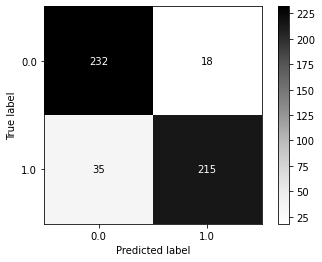

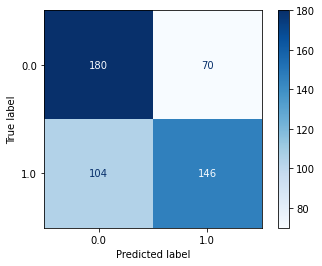

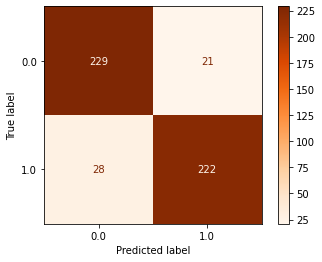

In [17]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix 

plot_confusion_matrix(logRes, X_test, y_test, cmap=plt.cm.Greys)
plot_confusion_matrix(sgd_clf, X_test_features, y_test, cmap=plt.cm.Blues)
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Oranges)

We can see the matrices in order
- Logistic Regression
- SVM
- Random Forest

We can now use the classification report function to get f1 score, precision and recall values

In [18]:
from sklearn.metrics import classification_report

lr_pred = logRes.predict(X_test)
sgd_pred = sgd_clf.predict(X_test_features)
rf_pred = rf.predict(X_test_arr)
# svc_pred = svc_classifier.predict(X_test_arr)
print("Logistic Regression")
print(classification_report(y_test, lr_pred))
print("--------------------")
print("Stochastic Gradient Descent")
print(classification_report(y_test, sgd_pred))
print("--------------------")
print("Random Forest")
print(classification_report(y_test, rf_pred))
print("--------------------")

Logistic Regression
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90       250
         1.0       0.92      0.86      0.89       250

    accuracy                           0.89       500
   macro avg       0.90      0.89      0.89       500
weighted avg       0.90      0.89      0.89       500

--------------------
Stochastic Gradient Descent
              precision    recall  f1-score   support

         0.0       0.63      0.72      0.67       250
         1.0       0.68      0.58      0.63       250

    accuracy                           0.65       500
   macro avg       0.65      0.65      0.65       500
weighted avg       0.65      0.65      0.65       500

--------------------
Random Forest
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90       250
         1.0       0.91      0.89      0.90       250

    accuracy                           0.90       500
   macro avg       0.90 

We want to minimize the **False Positives**, so it appears **Random Forest** is our best candidate. We can see a **f1** score of **.90** here, let's do Cross Validation and Hyper Param Tuning and see if this goes up.

## Cross Validation and Hyper-param tuning

To verify we have the best possible results, we can perform some hyper param tuning and see if it can assist us. We will use GridSearchCV and RepeatedKFold methods to achieve the 10-fold CV. We can use the scores to get the ideal value of a key parameter by minimizing Misclassification Error (or improving Cross Validation score since they are inversely proportional)

In [19]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
# define search space
param_grid = { 
    'n_estimators': [10, 50, 100, 150, 200, 250],
    'max_features': ['auto', 'log2'],
    'max_depth' : [10,25,45,50,55,60],
}
# define search
search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=param_grid, scoring='f1', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9172168658451323
Best Hyperparameters: {'max_depth': 60, 'max_features': 'auto', 'n_estimators': 250}


## Training optimized model with above hyperparams

In [20]:
rf_optimized = RandomForestClassifier(random_state=0, max_depth=60, max_features='auto',n_estimators=250)
rf_optimized.fit(X_train_arr, y_train)

RandomForestClassifier(max_depth=60, n_estimators=250, random_state=0)

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       250
         1.0       0.93      0.90      0.91       250

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



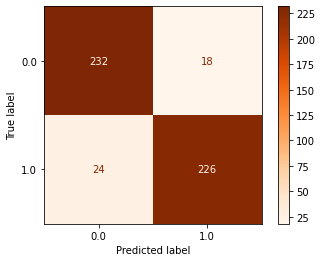

In [21]:
rf_optimized_pred = rf_optimized.predict(X_test_arr)
print(classification_report(y_test, rf_optimized_pred))
plot_confusion_matrix(rf_optimized, X_test, y_test, cmap=plt.cm.Oranges)

Looks like we were able to increase the **f1** score to **.92**, that's a good improvement!

### Pipelining

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
# define the stages of the pipeline
pipeline = Pipeline(steps= [('tfidf', TfidfVectorizer(lowercase=True,
                                                      stop_words= ENGLISH_STOP_WORDS)),
                            ('model', RandomForestClassifier(random_state=0, 
                                                             max_depth=60, 
                                                             max_features='auto',
                                                             n_estimators=250))])

# fit the pipeline model with the training data                            
#pipeline.fit(data2.text, data2.target)
pipeline.fit(X_text, y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
                                                       'anythin

## Manual Validation

In [24]:
real_post = '''The Business Analyst is responsible for working with business stakeholders to elicit, analyze, specify and validate IT solutions to meet business needs. This requires the ability to independently evaluate and transition to use of unfamiliar business and system domains. Must be able to bring together a diverse stakeholder group, drive consensus and create a shared understanding while maintaining alignment with business and IT strategies.

Reviews existing legacy applications and validates existing documentation of business requirements, processes and system specifications to develop an understanding of the existing functionality.
Maintains an up-to-date library of all business processes and IT/security/access system documentation including contacts, terms and key dates for renewals, expiries, etc.
Analyzes existing workflows and perform best practice benchmark gap analysis to identify opportunities to streamline processes, eliminate redundancy and ensure that processes are efficient, sustainable, and repeatable.
Meets with business leadership (SME, product manager, process owner) to understand new business requirements; creates and validates technical needs documentation.
Develops a clear definition and acceptance criteria for product features to ensure the business requirements will be addressed.
Participates in the implementation of new systems and applications; works closely with the business to device comprehensive test plans for different applications, business processes, and technical solutions.
Trains and supports users in conducting UAT and Pilot releases, creates test cases for all phases of testing, gathers feedback, tracks and reports defects, and follows up to ensure resolution of outstanding issues.
Provides and maintains required IT system training documentation to support all teams.
Responsible for fulfilling routine service requests (phone, email, tickets) and managing assigned incidents (including resolving the more routine incidents).
Supports the business in data extraction and manipulation from multiple systems to meet reporting needs.
Liaises with technology partners to resolve deficiencies, provide status updates and process information as needed.
Assesses risks associated with change; reviews change requests and analyzes the effect of proposed changes over all aspects of the business and communicates to all stakeholders.
Other duties as may be assigned to contribute to Dymon’s operational and financial success.
We are looking for a candidate with:

University Degree (preferably in computer science, Engineering or Information Technology)
3 - 5 years of experience as a Business Analyst
Experience working with NetSuite will be considered an asset
Excellent writing skills and effective communication
Possesses leading edge technical knowledge
Knowledge of Web Development and Software Development Life Cycle
Knowledge of SQL Server and BI tools
Strong business acumen; excellent understanding of business context and mode of operations
Ability to identify, formalize, and problem solve business needs
Exceptional interpersonal skills in areas such as teamwork, facilitation and negotiation
Understands principles of iterative development, and able to document business requirements
Expert in producing through and complete test scripts
Strong skills in organization, time management and collaboration
Able to work quickly and under tight delivery deadlines with focus on details
Interface with key customers from all functional areas
Proven and recent experience of implementing solutions from requirements gathering and process design to functional production deployment
Demonstrated ability to produce high quality deliverables
A good team player, able to maintain positive and effective work relationships with all levels of personnel within the organization
Your application must clearly demonstrate how you meet the requirements, as well as your commitment to a Guest-first approach. We thank all those who apply and apologize that we can only contact candidates who are selected for further consideration.

If you have a disability which requires an accommodation during any stage of our recruitment process, please let us know how we can assist you.

We have Great Perks * Health & Dental Plan * Paid Sick Days * Employee Assistance Program * Employee Educational Investments * Community Involvement Activities * Employee Recognition Awards * Training Opportunities * Team Events & Celebrations and more!

We welcome your interest in joining the DYMON Team!'''

scam_post = '''This is a real post, give us your social security and we give you job, promise really really'''
real_post_2 = '''Future You wants to know – what is life at UPS really like? You’ll see that it’s about opportunity, teamwork, a supportive culture and benefits that help you become everything you’re envisioning right now.Explore the many ways UPS can enrich life for Future You. And if you’d like benefit information, find it with the specific job you’re looking for.

Job Description:


POSITION SUMMARY

The UPS walker performs the task of delivering and picking up UPS packages. The responsibilities consist of the following:


KEY ACCOUNTABILITIES


- Delivering and picking up UPS packages efficiently and effectively
- Learning and properly executing UPS safe driving methods to ensure passenger safety
- Complying with UPS appearance guidelines


EDUCATION/WORK EXPERIENCE


- Ability to lift up to 70 lbs
- Ability to work in a fast paced environment
- Bilingualism
- Available to work daily Monday through Friday

- lexible to work any 4 hour shift between the hours of 7:00 and 22:00
- Able to work under minimal supervision
- Strong customer service skills

UPS Canada is a diverse and equal opportunity employer. Please advise our HR representatives if workplace accommodation is needed. Thank you for your interest in UPS Canada.'''


pipeline.predict([real_post, scam_post, real_post_2])

array([0., 1., 0.])

### Saving Model

In [25]:
# import joblib
from joblib import dump

# dump the pipeline model
dump(pipeline, filename="scam_finder.joblib")

['scam_finder.joblib']

### Loading model back and trying the results

In [26]:
# import joblib
from joblib import load

text = [real_post, scam_post, real_post_2]

# load the saved pipleine model
pipeline = load("scam_finder.joblib")

print(pipeline.predict(text))
print(pipeline.predict_proba(text))

[0. 1. 0.]
[[0.5113089  0.4886911 ]
 [0.42168063 0.57831937]
 [0.54656472 0.45343528]]


In [27]:
a = pipeline.predict_proba([real_post])

In [28]:
a[0][0]

0.511308902436951